# 1. Scope
The objective of this document will be to expand the model obtained in iteration I, by rethinking the problem as a binary classification (positive / negative) of the reviews instead of a 5 star scale. The model error is expected to be substantially reduced.

In the first place and for information purposes, results of **`iteration I`** will be recapped. Then, some steps will be modified to adapt the methodology to the new approach.

Additionally, an algorithm will be applied to 3-star reviews to see if they are mostly positive or negative reviews. This will show if users "forgive" the quality of some product category more than another, or if there is a bias in product rating.

Finally, an analysis of the conclusions obtained and a meta-analysis of the applied methodology will be carried out.

# 2. Recap: iteration I

The first iteration starts with a comprehensive `EDA` and preprocessing, which includes text normalization through SpaCy pipeline (`tok2vec`, `morphologizer`, `parser`, `ner`, `attribute_ruler` and `lemmatizer`), stopwords removal and lemmatization in order to improve model's accuracy. Then, a performance metric has been selected.
  
After that, a benchmark model has been developed and compared with other two other models in order to determine the best performing one. The one that showed the best accuracy has had its hyperparameters optimized and finally some conclusions have been made about the performance and the methodology applied.

### Results
- Selected metric: **`accuracy`**
- Best performing method: **`LinearSVC`**. Hyperparameters: `C`: **1**; `loss`: **squared_hinge**; `penalty`: **l2**; `tol`: **0.0001**
- Accuracy LinearSVC without optimization on test: **0.5252**
- Tf-idf optimization method: *changing n-gram range from unigram to trigram*
- Optimization technique: **`GridsearchCV`**
- Optimized hyperparameters for LinearSVC: `C`: **10**; `loss`: **squared_hinge**; `penalty`: **l2**; `tol`: **0.01**
- Accuracy LinearSVC optimized: **0.5427**

# 3. Iteration II - Model repurposing

## Motivation: The 5-star scale problem

The 5-star reputation system, although it can provide more detailed information than the binary classification, has some limitations:
- In product *marketplaces* (as in the case of Amazon) it is very practical to separate bad products from those that are not, although it tends to present difficulties in separating very good products from those that are just good.
- Users do not have incentives to provide feedback for "average" experiences (neither good nor bad), so they generate selection biases (fewer intermediate reviews)
- There will always be subjective biases for the interpretation of intermediate reviews and the score that each product deserves. This can depend on the personal interpretation of the quality or to the amount of experiences a user had with a certain type of product.

It is clear that although these systems are more ambitious since they intend to know the opinions of users with greater granularity, the results lose precision and the added value of this greater detail ends up not being so significant.

Due to these issues, services such as YouTube or Netflix have abandoned the star system in favor of other binaries (thumbs up / down), as well as other social networks that started using likes / upvotes systems. What these systems lose in detail they gain in the robustness of the evaluation of their publications

## Preprocessing

I will first load relevant libraries

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
import random

import es_core_news_sm

from collections import Counter
import itertools

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

Dataset load

In [2]:
df_p4 = pd.read_json('dataset_es_dev.json',lines=True)
df_test_p4 = pd.read_json('dataset_es_test.json',lines=True)
df_train_p4 = pd.read_json('dataset_es_train.json',lines=True)

To facilitate data processing, I will join the reviews with their titles in the same column (`whole_review`), making the text lower case, eliminating the `review_body` and `review_title` attributes containing this information separately and discarding all other columns.

In [3]:
df_p4['full_review'] = df_p4['review_title'] + ' ' + df_p4['review_body']
df_p4['full_review'] = df_p4['full_review'].str.lower()
df_no3s_p4 = df_p4[df_p4.stars != 3]
df_p4 = df_p4.drop(columns=['language', 'product_id', 'reviewer_id', 'review_body', 'review_title'])

df_test_p4['full_review'] = df_test_p4['review_title'] + ' ' + df_test_p4['review_body']
df_test_p4['full_review'] = df_test_p4['full_review'].str.lower()
df_test_p4 = df_test_p4.drop(columns=['language', 'product_id', 'reviewer_id', 'review_body', 'review_title'])

df_train_p4['full_review'] = df_train_p4['review_title'] + ' ' + df_train_p4['review_body']
df_train_p4['full_review'] = df_train_p4['full_review'].str.lower()
df_train_p4 = df_train_p4.drop(columns=['language', 'product_id','reviewer_id', 'review_body', 'review_title'])

In the next cell:
- I will load the `pipeline` in Spanish of **`spaCy`**. This, as can be seen in the diagram below, applies some transformations to the text that we pass through it. According to its documentation, the applied transformations are: `tok2vec`, `morphologizer`, `parser`, `ner`, `attribute_ruler` and `lemmatizer`.

<img src="https://d33wubrfki0l68.cloudfront.net/3ad0582d97663a1272ffc4ccf09f1c5b335b17e9/7f49c/pipeline-fde48da9b43661abcdf62ab70a546d71.svg" alt="Drawing" style="width: 600px;"/>

- I will load the common words (stopwords) in Spanish and then filter them

In [4]:
nlp = es_core_news_sm.load()

sw = nlp.Defaults.stop_words

Through the following function I will apply **`normalization`** to the text of each row. This includes:
- The preprocessing mentioned above with `nlp`
- All words will become lowercase
- Commas, periods and 1-letter words will be eliminated (for example "y" [eng: *and*], "a" [eng: *to*], etc)
- The `stopwords` will be removed. These are words that are meaningless on their own, such as prepositions, articles, conjunctions, pronouns, etc.

The objective of this preprocessing, which will reduce text noise by eliminating inflectional and sometimes derivationally related forms to a common base *, is to facilitate the subsequent analysis of each review using classification algorithms. In this way, the number of stars that a user would give a product given a review can be predicted with greater precision.

\* "**Stemming and lemmatization", Stanford, Cambridge University Press, 2008, https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html**

In [5]:
def process(text):
    review_tk = nltk.RegexpTokenizer('\w+').tokenize(text)
    review_tk_min = [word.lower() for word in review_tk if word.lower() not in sw]
    review_clean = ' '.join(review_tk_min)
    review_clean = nlp(review_clean)
    review_lemm = [word.lemma_ for word in review_clean]
    review_lemm = [t for t in review_lemm if len(t)>1]
    return review_lemm

I apply the processing to the 3 dataframes separately

In [6]:
df_p4['full_review_tk'] = df_p4.apply(lambda row: process(row['full_review']), axis=1)
df_test_p4['full_review_tk'] = df_test_p4.apply(lambda row: process(row['full_review']), axis=1)
df_train_p4['full_review_tk'] = df_train_p4.apply(lambda row: process(row['full_review']), axis=1)

I save the results again in **`.xlsx`** files as a checkpoint

In [7]:
df_p4.to_excel('ml_df.xlsx')
df_test_p4.to_excel('ml_df_test.xlsx')
df_train_p4.to_excel('ml_df_train.xlsx')

In [8]:
df_p4.head(5)

,review_id,stars,product_category,full_review,full_review_tk
0,es_0417480,1,wireless,"mala compra malisimo, muy grande demasiado apa...","[malo, compra, malisimo, grande, aparatoso, pr..."
1,es_0180432,1,apparel,no lo he recibido no he recibido el pedido no ...,"[recibido, recibido, pedido, devolución]"
2,es_0144850,1,sports,que no aprieta bien en el manillar tengo que b...,"[aprieta, manillar, buscar, sistema, funcionar..."
3,es_0339629,1,home_improvement,brocas de mantequilla utilicé las brocas de me...,"[broca, mantequillar, utilicé, broca, menor, d..."
4,es_0858362,1,beauty,no me gusta no me gusta su olor a viejo y aspe...,"[gustar, gusta, olor, viejo, aspecto, malo]"


In [9]:
df_p4['full_review_tk'] = df_p4['full_review'].apply(str)
df_test_p4['full_review_tk'] = df_test_p4['full_review'].apply(str)
df_train_p4['full_review_tk'] = df_train_p4['full_review'].apply(str)

Next, I remove the 3-star reviews from the dataset to keep it balanced and be able to work on the more clearly positive / negative ones, replacing the 2-star rating with 1-star and the 4-star by 5-star. Also I remove the `full_review` column without tokenizing. On this reduced dataset I will work to train the new model

In [10]:
df_p4_no3s = df_p4[df_p4.stars != 3]
df_test_p4_no3s = df_test_p4[df_test_p4.stars != 3]
df_train_p4_no3s = df_train_p4[df_train_p4.stars != 3]

df_p4_no3s['stars'] = df_p4_no3s['stars'].replace(2,1)
df_p4_no3s['stars'] = df_p4_no3s['stars'].replace(4,5)

df_test_p4_no3s['stars'] = df_test_p4_no3s['stars'].replace(2,1)
df_test_p4_no3s['stars'] = df_test_p4_no3s['stars'].replace(4,5)

df_train_p4_no3s['stars'] = df_train_p4_no3s['stars'].replace(2,1)
df_train_p4_no3s['stars'] = df_train_p4_no3s['stars'].replace(4,5)

df_p4_no3s = df_p4_no3s.drop(columns=['full_review'])
df_test_p4_no3s = df_test_p4_no3s.drop(columns=['full_review'])
df_train_p4_no3s = df_train_p4_no3s.drop(columns=['full_review'])

## Vectorization

I then vectorize the text through **`Tf-idf`** to be able to process text through machine learning

In [11]:
review_list_test = list(df_test_p4_no3s['full_review_tk'].values)
score_test = df_test_p4_no3s['stars'].values

review_list_train = list(df_train_p4_no3s['full_review_tk'].values)
score_train = df_train_p4_no3s['stars'].values 

review_list = list(df_p4_no3s['full_review_tk'].values)
score = df_p4_no3s['stars'].values 

#TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=1000, min_df=30)

# Compute the word counts, idf and tf-idf values all at once
review_matrix_test = tfidf.fit_transform(review_list_test)
review_matrix_train = tfidf.transform(review_list_train)
review_matrix = tfidf.transform(review_list)

print('Train', review_matrix_train.shape)
print('Test', review_matrix_test.shape)
print('Data', review_matrix.shape)

Train (160000, 744)
Test (4000, 744)
Data (4000, 744)


In [12]:
review_matrix_train = review_matrix_train.astype('float32')
score_train = score_train.astype('int8')

review_matrix_test = review_matrix_test.astype('float32')
score_test = score_test.astype('int8')

review_matrix = review_matrix.astype('float32')
score = score.astype('int8')

Set test and train matrices

In [13]:
#TRAIN
X_train = review_matrix_train.toarray()
y_train = score_train

#TEST
X_test = review_matrix_test.toarray()
y_test = score_test

#DATA
X = review_matrix.toarray()
y = score

## Model training and optimization

Next, I will train the `LinearSVC` model using as a starting point the hyperparameters obtained in iteration I:

- `C`: **10**
- `loss`: **'squared_hinge'**
- `penalty`: **'l2'**
- `tol`: **0.01**

In [14]:
svc = LinearSVC(C=10,loss='squared_hinge',penalty='l2',tol = 0.01)
svc.fit(X_train, y_train)

y_train_pred= svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print("Accuracy train binary LinearSVC: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test binary LinearSVC: ", accuracy_score(y_test, y_test_pred))

Accuracy train binary LinearSVC:  0.902525
Accuracy test binary LinearSVC:  0.9015


As expected, by reducing the complexity of the model, the accuracy increased significantly.

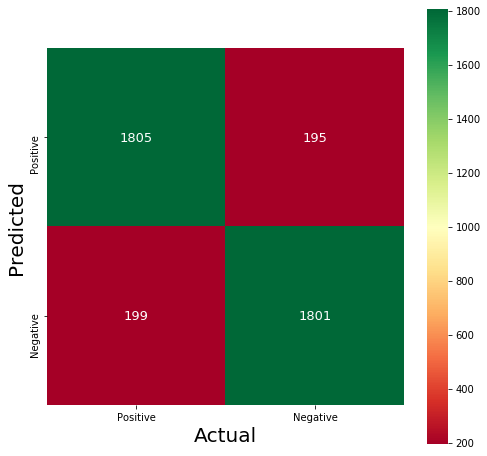

In [15]:
score = ["Positive","Negative"]
cm = confusion_matrix(y_test,y_test_pred)
f,ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, square = True, annot=True, fmt= '.0f',annot_kws={'size': 13}, cmap= 'RdYlGn',ax=ax)

plt.xlabel("Actual", size =20)
plt.ylabel("Predicted", size =20)
ax.set_xticklabels(score)
ax.set_yticklabels(score)
plt.show()

We can see that the model tends to generate more false negatives, although the error is broadly balanced.

I will optimize its hyperparameters by using the same method as in Iteration I (`GridSearchCV`)

In [16]:
svc_opt = LinearSVC() 

parameters =  {'C': [0.001, 10, 25, 100, 500],
                'penalty':['l1','l2'],
                'tol': [1e-2, 1e-4],
                'loss': ['hinge', 'squared_hinge']}              


CV_svc = GridSearchCV(estimator=svc_opt, param_grid=parameters, cv= 2,error_score=0.0)
CV_svc.fit(X_train, y_train)
print(CV_svc.best_params_)

C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-tes

C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=True

  FitFailedWarning)
C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-tes

C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to 0.000000. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True, Parameters: penalty='l1', loss='squared_hinge', dual=True

  FitFailedWarning)
C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear f

{'C': 500, 'loss': 'hinge', 'penalty': 'l2', 'tol': 0.01}


C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We can see that the new optimized hyperparameters will be:
- `C`: **500**
- `loss`: **'hinge'**
- `penalty`: **'l2'**
- `tol`: **0.01**

So, I retrain the optimized SVC model with the results obtained:

C:\Users\gpozz\.conda\envs\Datascience\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy train binary optimized LinearSVC:  0.902525
Accuracy test binary optimized LinearSVC:  0.9015


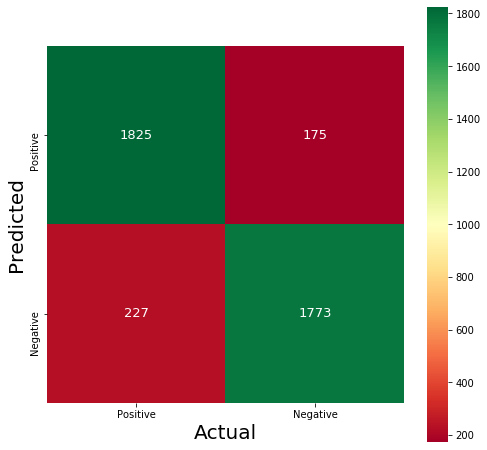

In [17]:
svc_opt = LinearSVC(C=500,loss='hinge',penalty='l2',tol = 0.01)
svc_opt.fit(X_train, y_train)

y_train_pred_opt= svc_opt.predict(X_train)
y_test_pred_opt = svc_opt.predict(X_test)

print("Accuracy train binary optimized LinearSVC: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test binary optimized LinearSVC: ", accuracy_score(y_test, y_test_pred))

score=["Positive","Negative"]
cm = confusion_matrix(y_test,y_test_pred_opt)
f,ax = plt.subplots(figsize=(8,8))
sns.heatmap(cm, square = True, annot=True, fmt= '.0f',annot_kws={'size': 13}, cmap= 'RdYlGn',ax=ax)

plt.xlabel("Actual", size =20)
plt.ylabel("Predicted", size =20)
ax.set_xticklabels(score)
ax.set_yticklabels(score)
plt.show()

Although the hyperparameters were optimized, the gain is imperceptible, deepening the bias by a small amount, since it generates some more false negatives and more true positives.

I will again plot the frequency of each unigram, bigram, or trigram in positive reviews.

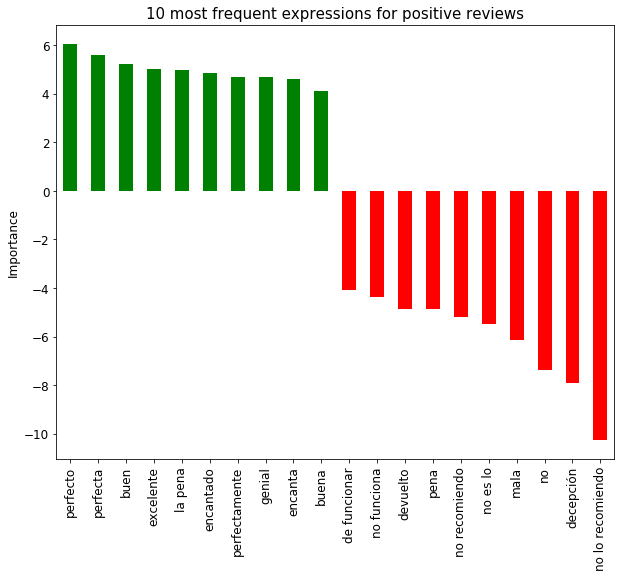

In [18]:
all_words = tfidf.get_feature_names()

coef = list(svc_opt.coef_[0])
label = list(all_words)
words = pd.DataFrame()
words['Features'] = label
words['Importance'] = coef
features = words.reset_index(drop=True)
sorted_words = features.sort_values(by=['Importance'], ascending=False)
sorted_words = sorted_words.reset_index(drop=True)
data_plot = pd.concat([sorted_words.head(10), sorted_words.tail(10)])
data_plot.sort_values(by=['Importance'], ascending=False, inplace = True)
data_plot['positive'] = data_plot['Importance'] > 0
data_plot.set_index('Features', inplace = True)
data_plot.Importance.plot(kind='bar', figsize = (10,8),
                          color = data_plot.positive.map({True: 'green', False: 'red'}),
                          fontsize=12)
plt.xlabel ('', fontsize=12)
plt.ylabel ('Importance', rotation = 90, fontsize=12)
plt.title ('10 most frequent expressions for positive reviews', fontsize=15)
plt.show()

In the next cell, some random 3-star reviews will be classified according to the score (positive or negative) that the developed model predicts for them.

In [19]:
df_amazon_bin = pd.concat([df_p4,df_test_p4,df_train_p4],axis=0)
df_amazon_bin = df_amazon_bin[df_amazon_bin['stars']==3]
df_amazon_bin.reset_index(inplace=True)

for i in range(1,6):
    n = random.randint(df_amazon_bin.index[0],df_amazon_bin.index[-1])
    review = df_amazon_bin['full_review'][n]
    review = [review]
    matrix= tfidf.transform(review)
    matrix = matrix.astype('float32')
    X = matrix.toarray()
    y_train_pred_test = svc_opt.predict(X)
    if y_train_pred_test == 0:
        y_train_pred_test = "Positive"
    else:
        y_train_pred_test = "Negative"
    print('Review: ',review[0], '- Score: ',y_train_pred_test)

Review:  gracioso a mi nieta de dos años le encanto. pero las canciones solo han durado un día. el botoncito del ala es muy delicado y ya no funciona y no canta. si que funciona y le divierte cuando repite lo que dices. lastima que sea tan poco duradero, pues es muy gracioso. - Score:  Negative
Review:  tardaron lo indecible ya lo daba por perdido... - Score:  Negative
Review:  se estropea rápido el teléfono me encanta pero tiene 15 días y ya me ha fallado la pantalla... - Score:  Negative
Review:  tiene buena calidad. el manual de instruciones no esta en español. - Score:  Negative
Review:  realmente no podía pedir más el producto no es nada del otro mundo, al fin y al cabo por el precio que tiene no puedes esperar un papel de 100 gramos, pero las hojas son muy finas, incluso se transparenta la tinta de la pagina siguiente si hay un poco de luz solar. el encuadernado es de tapa dura y muy bonito, así que no tiene nada de malo. en general, por su precio-calidad está bien. - Score:  Neg

## 4. Analysis: 3-star reviews

In this section, I will analyze the 3-star reviews by applying to them the algorithm obtained to visualize how many of them could be classified as negative and how many as positive.

Next, I will append the prediction of the model to the original dataframe, by replacing the result 1 with the text "Negative" and 5 with the text "Positive" in order to more easily visualize the results obtained.

In [20]:
df_amazon_bin2 = pd.concat([df_p4,df_test_p4,df_train_p4],axis=0)
df_amazon_bin2.reset_index(drop=True,inplace=True)
df_amazon_bin2['Pred']=''

for i in range(0,df_amazon_bin2.shape[0]):
    review = df_amazon_bin2['full_review_tk'][i]
    review = [review]
    matrix= tfidf.transform(review)
    matrix = matrix.astype('float32')
    X = matrix.toarray()
    y_train_pred_test = svc_opt.predict(X)
    df_amazon_bin2['Pred'][i] = int(y_train_pred_test)
    
    
df_amazon_bin2['Pred'] = df_amazon_bin2.Pred.replace(to_replace =1, 
                            value ="Negative")
df_amazon_bin2['Pred'] = df_amazon_bin2.Pred.replace(to_replace =5, 
                            value ="Positive")

df_amazon_bin_3s = df_amazon_bin2[df_amazon_bin2['stars']==3]
print('There are ',str(df_amazon_bin_3s[df_amazon_bin_3s['Pred']=='Positive'].shape[0]),' positive 3-star reviews')
print('There are ',str(df_amazon_bin_3s[df_amazon_bin_3s['Pred']=='Negative'].shape[0]),' negative 3-star reviews')

There are  17467  positive 3-star reviews
There are  24533  negative 3-star reviews


We can see that, in general terms, users who score 3 stars to a greater extent "forgive" the quality of the products since, although their scores indicate a neutral rating, their reviews indicate a mostly negative perception.

In the next table and in order to answer the question indicated in the introduction, I will group the reviews with a neutral score (**3 stars**) by category and predict their rating. I will store the ratio of positive to negative reviews in the "Bias" column. This should be a good indicator of the indulgence with which users rate the quality of the products purchased, a higher score being an indication that in the event of a bad perception the user scores neutral so as not to harm the seller's reputation.

In [22]:
dfpos = df_amazon_bin_3s[df_amazon_bin_3s['Pred']=="Positive"].groupby(by=['product_category']).count()[['Pred']]
dfall = dfpos.merge(df_amazon_bin_3s[df_amazon_bin_3s['Pred']=="Negative"].groupby(by=['product_category']).count()[['Pred']],how='outer', left_index=True, right_index=True)
dfall.rename(columns={'Pred_x':'Positives','Pred_y':'Negatives'},inplace=True)
dfall['Bias'] = dfall['Negatives']/dfall['Positives']
dfall.sort_values(by='Bias',ascending=False)

,Positives,Negatives,Bias
product_category,,,
beauty,545,1068,1.959633
shoes,201,386,1.920398
video_games,121,193,1.595041
drugstore,450,702,1.560000
grocery,89,138,1.550562
pet_products,318,490,1.540881
electronics,796,1192,1.497487
wireless,2023,3023,1.494315
toy,1268,1865,1.470820


The 5 categories that users tend to "forgive" the most are:
- `beauty`
- `shoes`
- `video_games`
- `drugstore`
- `grocery`

# 5. Conclusions

- We can observe that what the model loses in detail when changing to a binary classification it gains in greater robustness of its predictions.

- Within the "neutral" reviews (3 stars) we can see a marked bias of users to classify apparently negative reviews as neutral, more pronounced in the categories `shoes`, `beauty`, `grocery`, `pet_products` and `wireless`. There are no categories in which the bias is inverse, so it is expected that the user, faced with little-above-average experience, tends to rate it with 4 stars, while if the experience is not very satisfactory, it tends to qualify it as neutral (3 stars).

- Without necessarily substituting 5-star ratings, some benefits of implementing an algorithm that rates reviews in a binary way could be:
    - It can serve to penalize the score of poorly rated reviews, where the user writes a mostly positive text and presses 1
    or 2 stars, or vice versa.
    - It allows to identify users that are consistently generous or, on the contrary, too demanding with the scores to qualify their opinion in the final score and improve its quality.
    - It can be used to identify perception bias of certain categories. Thus, if a category has a marked tendency to undervalue products (with a greater number of positive opinions on neutral scores), the opinion of users about this category could be nuanced, compensating for this bias in some way in the calculation of the product score / seller. In this way, seller ratings from different categories could be comparable to each other and identify the best ones, allowing to compensate them or offer partnerships and other benefits for offering good customer experiences.

Finally, it should be mentioned that there is room for improvement for the model, although the accuracy obtained is satisfactory for the utility that it is intended to provide.